## Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(2)

Using Theano backend.


# Data loading and visualization

In [3]:
# Load data
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [4]:
# Training data description
# test data will not have the label column
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

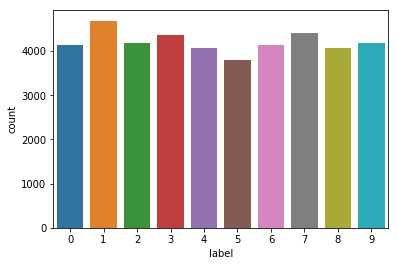

In [5]:
# Store the labels
Y_train = train['label']

# Drop the label column and store the data as input
X_train = train.drop(labels=['label'], axis=1)

# Visulalization and description of outputs
g = sns.countplot(Y_train)
Y_train.value_counts()

In [6]:
# Check for null and missing values in training data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
# Check for null and missing values in test data
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
X_train.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
# Normalization (grayscale to increase performance of CNN)
X_train /= 255
test /= 255

In [10]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# Keras requires an extra dimension in the end which correspond to channels. 
# Since MNIST images are gray scaled so it uses only one channel.
# For RGB images, there are 3 channels,
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [11]:
# Encode labels to one hot vectors (10 classes: 0-9)
Y_train = to_categorical(Y_train, num_classes=10)

In [12]:
random_seed = 2

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.1, random_state=random_seed
)

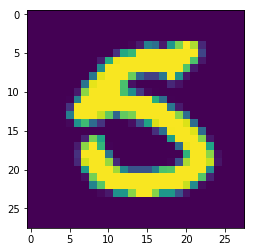

In [13]:
# see an example
g = plt.imshow(X_train[4][:,:,0])

# CNN

In [14]:
# Set CNN model
# architecture used: In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 ->
# Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(
    filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)
))
model.add(Conv2D(
    filters=32, kernel_size=(5,5), padding='Same', activation='relu'
))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(
    filters=32, kernel_size=(5,5), padding='Same', activation='relu'
))
model.add(Conv2D(
    filters=32, kernel_size=(5,5), padding='Same', activation='relu'
))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [15]:
# Define the optimize
optimizer = RMSprop(lr=0.001, epsilon=1e-08)

In [16]:
# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Learning rate annealer
# LR is reduced by half if the accuracy is not improved after 3 epochs.

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=0.00001
)

In [18]:
epochs = 30
batch_size = 86

# Data Augmentation

In [19]:
# Applying data augmentation to prevent overfitting.
# We don't apply horizontal and vertical fluipping because then the model
# would misclassify numbers 6 and 9.

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images by 10 degrees
    zoom_range = 0.1, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)

In [20]:
# Fit the model
history = model.fit_generator(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=2,
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)

Epoch 1/30
 - 302s - loss: 0.4163 - acc: 0.8634 - val_loss: 0.0677 - val_acc: 0.9788
Epoch 2/30
 - 285s - loss: 0.1331 - acc: 0.9605 - val_loss: 0.0417 - val_acc: 0.9876
Epoch 3/30
 - 285s - loss: 0.0964 - acc: 0.9715 - val_loss: 0.0333 - val_acc: 0.9895
Epoch 4/30
 - 284s - loss: 0.0834 - acc: 0.9763 - val_loss: 0.0347 - val_acc: 0.9895
Epoch 5/30
 - 296s - loss: 0.0741 - acc: 0.9783 - val_loss: 0.0290 - val_acc: 0.9924
Epoch 6/30
 - 279s - loss: 0.0674 - acc: 0.9803 - val_loss: 0.0348 - val_acc: 0.9926
Epoch 7/30
 - 278s - loss: 0.0642 - acc: 0.9812 - val_loss: 0.0237 - val_acc: 0.9921
Epoch 8/30
 - 281s - loss: 0.0634 - acc: 0.9820 - val_loss: 0.0333 - val_acc: 0.9910
Epoch 9/30
 - 278s - loss: 0.0612 - acc: 0.9828 - val_loss: 0.0250 - val_acc: 0.9926
Epoch 10/30
 - 277s - loss: 0.0589 - acc: 0.9838 - val_loss: 0.0224 - val_acc: 0.9936
Epoch 11/30
 - 288s - loss: 0.0609 - acc: 0.9833 - val_loss: 0.0254 - val_acc: 0.9938
Epoch 12/30
 - 277s - loss: 0.0612 - acc: 0.9832 - val_loss: 0.

# Model Evaluation

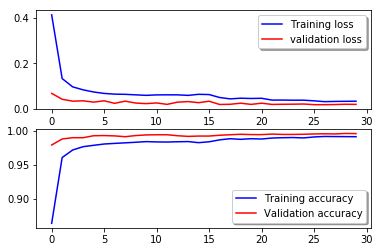

In [21]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [22]:
# Confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

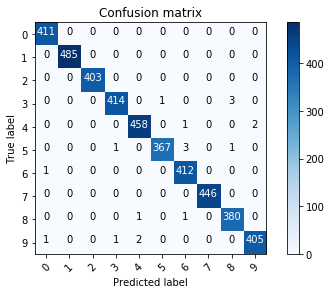

In [25]:
# Prdict values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis=1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

# Check Errors

In [26]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

In [27]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

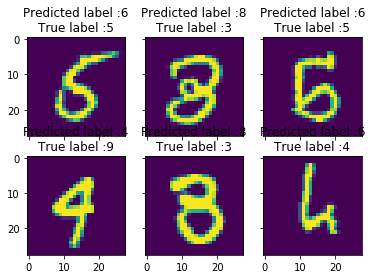

In [28]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_delta_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

# Predict Results and Submit

In [29]:
# predict results
results = model.predict(test)

# select the index with the maximum probability (convert from one-hot to decimal)
results = np.argmax(results, axis=1)

results = pd.Series(results, name='Label')

In [30]:
submission = pd.concat([pd.Series(range(1, 28001), name='ImageId'), results], axis=1)
submission.to_csv("cnn_mnist_datagen.csv", index=False)